## Important
`Some code cells are in "raw mode" (using key press [esc + r])`  
`To convert them to code cells which can be run, press [esc + y]`  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv


# Import remaining libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor

print("Imports completed!")

Imports completed!


In [3]:
# Basic funtions
def load_data(name):
    return pd.read_csv(f"/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/{name}.csv")

def inspect(df):
    print(f"Shape: {df.shape}\n")
    print(f"Columns: {df.columns}\n")
    df.info()
    print()
    print(f"Nulls: \n{df.isna().sum()}\n")
    return df.head()

In [4]:
# Functions to help transform the data

# To encode hour of the day, day of the week and other such cyclical data
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

In [5]:
# Function to preprocess data

def clean_data(df, fill_missing=True):
    # Fill missing values
#     missing = []
#     for col in missing:
#         df[col].fillna(df[col].median(), inplace=True)
    if fill_missing:
        df['passenger_count'].fillna(value=99, inplace=True)
        df['RatecodeID'].fillna(value=999, inplace=True)
        df['congestion_surcharge'].fillna(value=1.0, inplace=True)
        df['Airport_fee'].fillna(value=1.0, inplace=True)
        df['store_and_fwd_flag'].fillna(value="NA", inplace=True)
        
    # Clean outliers
    df['trip_distance'] = df['trip_distance'].apply(lambda x: (x / 10000) if x > 1000 else x)
    
    # Handle date columns
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
#     df['Travel_time'] = pd.to_datetime(df['tpep_dropoff_datetime']) - pd.to_datetime(df['tpep_pickup_datetime'])
    
    # Extract day and hour of pickup and dropoff
    df["pu_day"] = df["tpep_pickup_datetime"].dt.day.astype('str')
    df["do_day"] = df["tpep_dropoff_datetime"].dt.day.astype('str')
    df["pu_hr"] = df["tpep_pickup_datetime"].apply(lambda x: x.hour)
    df["do_hr"] = df["tpep_dropoff_datetime"].apply(lambda x: x.hour)
    
    # Encode hour and day as cyclical features using sine and cosine transformations
    df = encode_cyclical(df, 'pu_hr', 24)
    df = encode_cyclical(df, 'do_hr', 24)
    
    # Apply transformations
    df['log_trip_distance'] = df['trip_distance']
    df['log_trip_distance'] = df['log_trip_distance'].replace({0: 0.01})
    df['log_trip_distance'] = df['log_trip_distance'].apply(lambda x: np.log(x))
    
    # Add new calculated columns
#     df['travel_duration'] = (df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].max(axis=1) 
#                              - df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].min(axis=1)).dt.total_seconds()
    df["put"] = df["tpep_pickup_datetime"]
    df["dot"] = df["tpep_dropoff_datetime"]
    df.loc[df["put"] > df["dot"], "dot"] = df["dot"] + pd.Timedelta(hours=1)
    df.loc[df["put"] > df["dot"], "dot"] = df["dot"] + pd.Timedelta(hours=1)    # This is deliberately done twice
    df["travel_time"] = (df["dot"] - df["put"]).dt.total_seconds() / 60

    # Trips based on LocationID combinations
    df["pu"] = df["PULocationID"].astype('str').str.zfill(3) 
    df["do"] = df["DOLocationID"].astype('str').str.zfill(3)
    df["pudo"] = df["pu"] + "," + df["do"]
    df["pudo"] = df["pudo"].apply(lambda x: "".join(sorted(x.split(","))))
    
    return df

In [6]:
# pd.to_datetime(traindf['tpep_dropoff_datetime']) - pd.to_datetime(traindf['tpep_pickup_datetime'])

In [7]:
traindf = load_data('train')
testdf = load_data('test')

In [8]:
inspect(traindf)

Shape: (175000, 17)

Columns: Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID      

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


## Clean train data

In [9]:
clean_data(traindf)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pu_hr_cos,do_hr_sin,do_hr_cos,log_trip_distance,put,dot,travel_time,pu,do,pudo
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,...,-0.258819,-8.660254e-01,-0.500000,0.760806,2023-06-28 17:20:21,2023-06-28 17:34:45,14.400000,120,009,009120
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,...,0.965926,-5.000000e-01,0.866025,0.993252,2023-06-29 23:05:01,2023-06-30 00:01:35,56.566667,015,215,015215
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,...,-0.866025,2.588190e-01,-0.965926,0.139762,2023-06-30 10:19:31,2023-06-30 11:13:10,53.650000,167,223,167223
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,...,-0.965926,-5.000000e-01,-0.866025,-0.916291,2023-06-29 13:23:09,2023-06-29 14:20:01,56.866667,128,239,128239
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,...,0.866025,-5.000000e-01,0.866025,0.095310,2023-06-29 22:03:32,2023-06-29 22:22:22,18.833333,203,052,052203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174995,1,2023-06-30 22:50:57,2023-06-30 22:22:22,3.0,3.45,1.0,N,147,167,Credit Card,...,0.866025,-5.000000e-01,0.866025,1.238374,2023-06-30 22:50:57,2023-06-30 23:22:22,31.416667,147,167,147167
174996,1,2023-06-30 13:03:33,2023-06-30 14:04:57,1.0,9.44,1.0,N,154,191,Cash,...,-0.965926,-5.000000e-01,-0.866025,2.244956,2023-06-30 13:03:33,2023-06-30 14:04:57,61.400000,154,191,154191
174997,0,2023-06-29 11:03:32,2023-06-29 12:13:34,1.0,2.40,1.0,N,168,106,Credit Card,...,-0.965926,1.224647e-16,-1.000000,0.875469,2023-06-29 11:03:32,2023-06-29 12:13:34,70.033333,168,106,106168
174998,1,2023-06-29 19:47:17,2023-06-29 19:08:55,1.0,4.71,1.0,N,240,100,Credit Card,...,0.258819,-9.659258e-01,0.258819,1.549688,2023-06-29 19:47:17,2023-06-29 20:08:55,21.633333,240,100,100240


In [10]:
inspect(traindf)

Shape: (175000, 32)

Columns: Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee', 'pu_day', 'do_day', 'pu_hr',
       'do_hr', 'pu_hr_sin', 'pu_hr_cos', 'do_hr_sin', 'do_hr_cos',
       'log_trip_distance', 'put', 'dot', 'travel_time', 'pu', 'do', 'pudo'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               175000 non-null  int64         
 1   tpep_pickup_datetime   175000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  175000 non-null  datetime64[ns]
 3   passenger_count      

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pu_hr_cos,do_hr_sin,do_hr_cos,log_trip_distance,put,dot,travel_time,pu,do,pudo
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,...,-0.258819,-0.866025,-0.500000,0.760806,2023-06-28 17:20:21,2023-06-28 17:34:45,14.400000,120,009,009120
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,...,0.965926,-0.500000,0.866025,0.993252,2023-06-29 23:05:01,2023-06-30 00:01:35,56.566667,015,215,015215
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,...,-0.866025,0.258819,-0.965926,0.139762,2023-06-30 10:19:31,2023-06-30 11:13:10,53.650000,167,223,167223
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,...,-0.965926,-0.500000,-0.866025,-0.916291,2023-06-29 13:23:09,2023-06-29 14:20:01,56.866667,128,239,128239
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,...,0.866025,-0.500000,0.866025,0.095310,2023-06-29 22:03:32,2023-06-29 22:22:22,18.833333,203,052,052203


In [11]:
traindf.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,...,pu_hr,do_hr,pu_hr_sin,pu_hr_cos,do_hr_sin,do_hr_cos,log_trip_distance,put,dot,travel_time
count,175000.000000,175000,175000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,...,175000.000000,175000.000000,1.750000e+05,175000.000000,1.750000e+05,1.750000e+05,175000.000000,175000,175000,175000.000000
mean,0.728377,2023-06-29 20:08:41.719628544,2023-06-29 20:26:35.299731712,4.748377,3.674865,36.156571,132.710349,132.701429,1.932143,6.127497,...,15.117183,15.103109,-3.786728e-01,-0.071988,-3.862083e-01,-4.176758e-02,0.683080,2023-06-29 20:08:41.719628544,2023-06-29 20:53:23.059731456,44.689002
min,0.000000,2023-06-28 15:26:39,2023-06-28 15:32:43,0.000000,0.000000,1.000000,1.000000,1.000000,-7.500000,0.000079,...,0.000000,0.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-4.605170,2023-06-28 15:26:39,2023-06-28 15:32:43,0.000000
25%,0.000000,2023-06-29 08:19:04,2023-06-29 08:33:55.750000128,1.000000,1.080000,1.000000,67.000000,67.000000,0.000000,3.473321,...,11.000000,11.000000,-8.660254e-01,-0.707107,-8.660254e-01,-7.071068e-01,0.076961,2023-06-29 08:19:04,2023-06-29 09:03:04.750000128,21.700000
50%,1.000000,2023-06-29 19:03:37.500000,2023-06-29 19:21:36,1.000000,1.840000,1.000000,133.000000,133.000000,1.000000,5.286217,...,16.000000,17.000000,-5.000000e-01,-0.258819,-5.000000e-01,-1.836970e-16,0.609766,2023-06-29 19:03:37.500000,2023-06-29 19:47:38.500000,40.450000
75%,1.000000,2023-06-30 12:33:12.500000,2023-06-30 12:52:20.249999872,1.000000,3.610000,1.000000,199.000000,199.000000,2.500000,7.502746,...,20.000000,20.000000,1.224647e-16,0.500000,1.224647e-16,7.071068e-01,1.283708,2023-06-30 12:33:12.500000,2023-06-30 13:18:00,57.583333
max,2.000000,2023-07-01 00:58:11,2023-07-01 23:10:43,99.000000,143.350000,999.000000,264.000000,264.000000,11.750000,484.876151,...,23.000000,23.000000,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,4.965289,2023-07-01 00:58:11,2023-07-01 23:10:43,1537.150000
std,0.445606,NaN,NaN,17.898255,4.879881,182.735828,76.148799,76.192493,1.948497,4.610834,...,5.772325,5.951523,6.228704e-01,0.680780,6.138107e-01,6.872699e-01,1.201231,NaN,NaN,45.475978


# Training data


In [12]:
X = traindf.drop('total_amount', axis=1).copy()
y = traindf['total_amount'].copy()
X.shape, y.shape

((175000, 31), (175000,))

In [13]:
X.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'pu_day', 'do_day', 'pu_hr', 'do_hr', 'pu_hr_sin',
       'pu_hr_cos', 'do_hr_sin', 'do_hr_cos', 'log_trip_distance', 'put',
       'dot', 'travel_time', 'pu', 'do', 'pudo'],
      dtype='object')

# Test data

In [14]:
testdf.shape

(50000, 16)

In [15]:
testdf.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee'],
      dtype='object')

In [16]:
testdf.isna().sum()

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          1779
trip_distance               0
RatecodeID               1779
store_and_fwd_flag       1779
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
congestion_surcharge     1779
Airport_fee              1779
dtype: int64

## Clean test data

In [17]:
clean_data(testdf)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pu_hr_cos,do_hr_sin,do_hr_cos,log_trip_distance,put,dot,travel_time,pu,do,pudo
0,1,2023-06-29 00:21:20,2023-06-29 00:25:20,1.0,4.95,1.0,N,20,3,Credit Card,...,1.000000e+00,0.000000,1.000000e+00,1.599388,2023-06-29 00:21:20,2023-06-29 00:25:20,4.000000,020,003,003020
1,1,2023-06-30 17:44:43,2023-06-30 17:53:13,1.0,2.10,1.0,N,9,81,Credit Card,...,-2.588190e-01,-0.965926,-2.588190e-01,0.741937,2023-06-30 17:44:43,2023-06-30 17:53:13,8.500000,009,081,009081
2,1,2023-06-29 18:17:04,2023-06-29 19:23:48,1.0,0.95,1.0,N,92,90,Cash,...,-1.836970e-16,-0.965926,2.588190e-01,-0.051293,2023-06-29 18:17:04,2023-06-29 19:23:48,66.733333,092,090,090092
3,0,2023-06-30 21:33:53,2023-06-30 21:46:20,1.0,0.80,1.0,N,19,102,Credit Card,...,7.071068e-01,-0.707107,7.071068e-01,-0.223144,2023-06-30 21:33:53,2023-06-30 21:46:20,12.450000,019,102,019102
4,1,2023-06-29 14:53:54,2023-06-29 15:22:17,1.0,4.01,1.0,N,131,229,Cash,...,-8.660254e-01,-0.707107,-7.071068e-01,1.388791,2023-06-29 14:53:54,2023-06-29 15:22:17,28.383333,131,229,131229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,2023-06-29 17:41:59,2023-06-29 18:30:36,1.0,0.61,1.0,N,48,72,Credit Card,...,-2.588190e-01,-1.000000,-1.836970e-16,-0.494296,2023-06-29 17:41:59,2023-06-29 18:30:36,48.616667,048,072,048072
49996,1,2023-06-30 01:25:25,2023-06-30 01:10:40,1.0,5.02,1.0,N,57,103,Cash,...,9.659258e-01,0.258819,9.659258e-01,1.613430,2023-06-30 01:25:25,2023-06-30 02:10:40,45.250000,057,103,057103
49997,1,2023-06-30 22:28:44,2023-06-30 21:49:37,1.0,1.92,1.0,N,150,78,Credit Card,...,8.660254e-01,-0.707107,7.071068e-01,0.652325,2023-06-30 22:28:44,2023-06-30 22:49:37,20.883333,150,078,078150
49998,0,2023-06-30 02:37:18,2023-06-30 02:10:33,1.0,5.40,1.0,N,4,154,Credit Card,...,8.660254e-01,0.500000,8.660254e-01,1.686399,2023-06-30 02:37:18,2023-06-30 03:10:33,33.250000,004,154,004154


In [18]:
testdf.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
extra                    0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
congestion_surcharge     0
Airport_fee              0
pu_day                   0
do_day                   0
pu_hr                    0
do_hr                    0
pu_hr_sin                0
pu_hr_cos                0
do_hr_sin                0
do_hr_cos                0
log_trip_distance        0
put                      0
dot                      0
travel_time              0
pu                       0
do                       0
pudo                     0
dtype: int64

# Dummy model

# EDA

# Functions for Plotting and Statistics

In [19]:
# Statistical tests
def ttest(df, value, group):
    # Perform independent samples t-test
    groups = [df[df[group] == g][value] for g in df[group].unique()]
    # print(groups)
    f_statistic, p_value, dof = sm.stats.weightstats.ttest_ind(*groups)
    return p_value

def ttest_v2(df, value, group):
    # Perform independent samples t-test
    groups = [df[df[group] == g][value] for g in df[group].unique()]
    # print(groups)
    f_statistic, p_value = stats.ttest_ind(*groups)
    return p_value

def anova(df, value, group):
    # Fit the ANOVA model
    model = ols(f'{value} ~ {group}', data=df).fit()

    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table

def anova_v2(df, value, group):
    # Perform ANOVA
    groups = [df[df[group] == g][value] for g in df[group].unique()]
    # print(groups)
    f_statistic, p_value = stats.f_oneway(*groups)
    return p_value

def pairwise_ttest(df, value, group):
    uniques = df[group].unique()
    for i in range(len(uniques) -1):
        for j in range(1, len(uniques)):
            if j > i:
                p = ttest_v2(df.loc[df[group].isin([uniques[i], uniques[j]])], value, group)
                print(f"P-value from t-test for {uniques[i]} vs {uniques[j]}: {p}")
    return
                
def chi_square_test():
    pass

def correlation(df, feature, label):
    return df[[feature, label]].corr()
    
def slr(df, feature, label, feature_type="num"):    # feature_type can be "num" or "cat"
    X, y = df[feature], df[label]
    linreg = LinearRegression()
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    if feature_type == "cat":
        ohe = OneHotEncoder(handle_unknown='ignore')
        x_train = ohe.fit_transform(x_train.to_numpy().reshape(-1, 1))
        x_test = ohe.transform(x_test.to_numpy().reshape(-1, 1))
        linreg.fit(x_train, y_train.to_numpy().reshape(-1, 1))
    elif feature_type == "num":
        ss = StandardScaler()
        x_train = ss.fit_transform(x_train.to_numpy().reshape(-1, 1))
        x_test = ss.transform(x_test.to_numpy().reshape(-1, 1))
        linreg.fit(x_train, y_train.to_numpy().reshape(-1, 1))
        
    y_pred = linreg.predict(x_test)
    
    return r2_score(y_test, y_pred)

In [20]:
# Plots and summaries
def explore_categorical(df, feature, label, pairwise_t=True):
    df = df.copy()
    # Describe
    print(f"value_counts for {feature}:\n\n {df[feature].value_counts()}")
    
    # Statistics
    print(f"\nStatistical tests:")
    print(f"\nANOVA test done. P-value: {anova_v2(df, label, feature)}")
    if pairwise_t:
        print(f"\nPair-wise t-tests done.")
        print(f"{pairwise_ttest(df, label, feature)}")
    
    # Plot
    df[feature] = df[feature].astype('str')    # Convert feature to string datatype
    print(f"\nPlotting all the graphs...\n")
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
    sns.countplot(data=df, x=feature, ax=ax[0])
    sns.barplot(data=df, x=feature, y=label, ax=ax[1])
    sns.boxplot(data=df, x=feature, y=label, showfliers=False, ax=ax[2])
    sns.lineplot(data=df, x=feature, y=label, ax=ax[3])
    return

def explore_continuous(df, feature, label, plot_reg_line=False):
    df = df.copy()
    # Describe
    print(f"Descriptive statistics for {feature}:\n\n {df[feature].describe()}")
    
    # Statistics
    print(f"\nStatistical tests:")
    print(f"\nCorrelation between {feature} and {label}: {correlation(traindf, feature, label).iloc[0, 1]}")
    print(f"R2-score for SLR on {feature} and {label}: {slr(df, feature, label)}")
    
    
    # Plot
    print(f"\nPlotting all the graphs...\n")
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
    sns.boxenplot(data=df, y=feature, ax=ax[0])
    sns.boxplot(data=df, y=feature, showfliers=False, ax=ax[1])
    sns.histplot(data=df, x=feature, kde=True, ax=ax[2])
    if plot_reg_line:
        sns.regplot(data=df, x=feature, y=label, ax=ax[3])
    else:
        sns.scatterplot(data=df, x=feature, y=label, ax=ax[3])
        
    return

In [21]:
## total_amount (label)

Descriptive statistics for total_amount:

 count    175000.000000
mean         29.633901
std          25.425206
min        -576.750000
25%          16.300000
50%          21.450000
75%          31.800000
max         587.250000
Name: total_amount, dtype: float64

Statistical tests:

Correlation between total_amount and total_amount: 1.0
R2-score for SLR on total_amount and total_amount: 1.0

Plotting all the graphs...



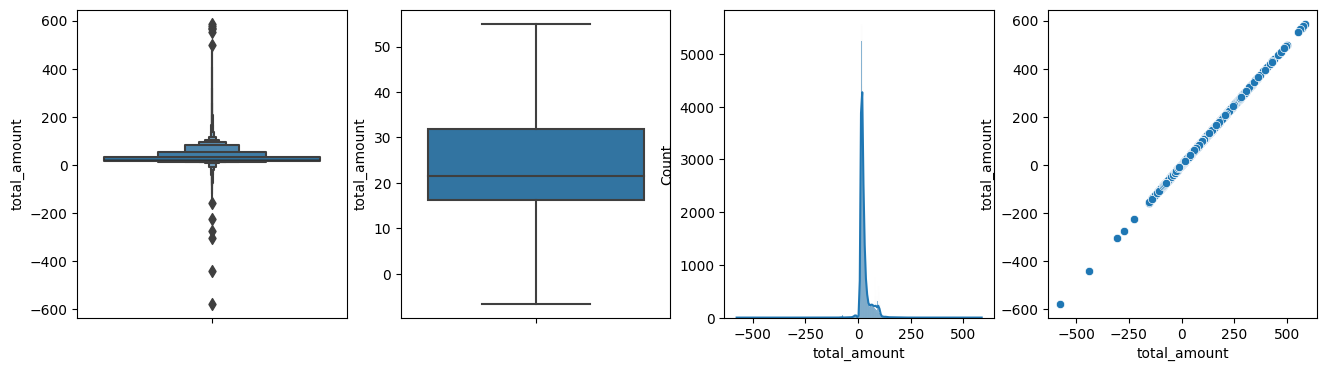

In [22]:
explore_continuous(traindf, "total_amount", "total_amount")

In [23]:
### VendorID

value_counts for VendorID:

 VendorID
1    127340
0     47597
2        63
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 1.993283937684375e-65

Pair-wise t-tests done.
P-value from t-test for 1 vs 0: 5.651911973286367e-60
P-value from t-test for 1 vs 2: 2.087436636667299e-07
P-value from t-test for 0 vs 2: 7.047375431527641e-12
None

Plotting all the graphs...



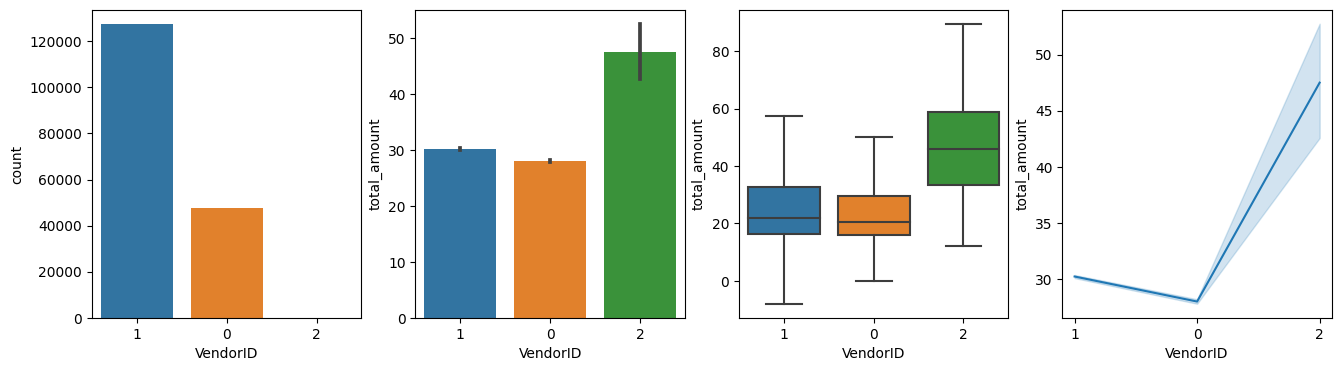

In [24]:
explore_categorical(traindf, 'VendorID', 'total_amount')

In [25]:
### tpep_pickup_datetime

In [26]:
# See below for extracted features

In [27]:
### tpep_dropoff_datetime

In [28]:
# See below for extracted features

In [29]:
### passenger_count

value_counts for passenger_count:

 passenger_count
1.0     128534
2.0      24316
99.0      6077
3.0       6018
4.0       3668
0.0       2818
5.0       1970
6.0       1596
8.0          2
9.0          1
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 2.724e-320

Plotting all the graphs...



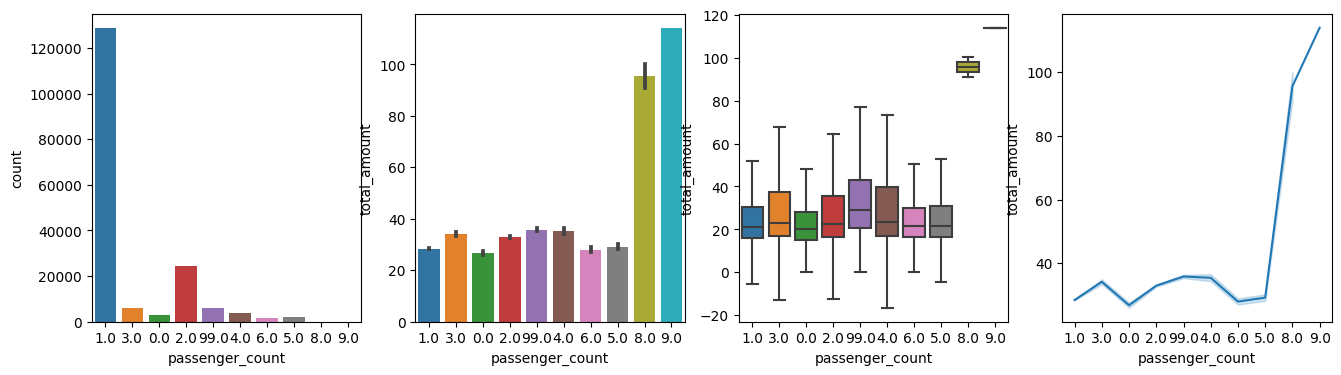

In [30]:
explore_categorical(traindf, 'passenger_count', 'total_amount', pairwise_t=False)

value_counts for passenger_count:

 passenger_count
1.0    128534
2.0     24316
3.0      6018
4.0      3668
0.0      2818
5.0      1970
6.0      1596
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 5.6470603316663755e-236

Pair-wise t-tests done.
P-value from t-test for 1.0 vs 3.0: 5.265910250272564e-69
P-value from t-test for 1.0 vs 0.0: 0.0003875237421541878
P-value from t-test for 1.0 vs 2.0: 2.563392491717164e-146
P-value from t-test for 1.0 vs 4.0: 3.668247295881629e-64
P-value from t-test for 1.0 vs 6.0: 0.4276078580820949
P-value from t-test for 1.0 vs 5.0: 0.17347286081225055
P-value from t-test for 3.0 vs 0.0: 1.2917967842658785e-28
P-value from t-test for 3.0 vs 2.0: 0.004056022847062048
P-value from t-test for 3.0 vs 4.0: 0.06588758663708043
P-value from t-test for 3.0 vs 6.0: 1.6714902003587055e-13
P-value from t-test for 3.0 vs 5.0: 1.4121285643339755e-10
P-value from t-test for 0.0 vs 2.0: 1.6328092968207667e-28
P-value from t-test for 0.0 vs 4.0:

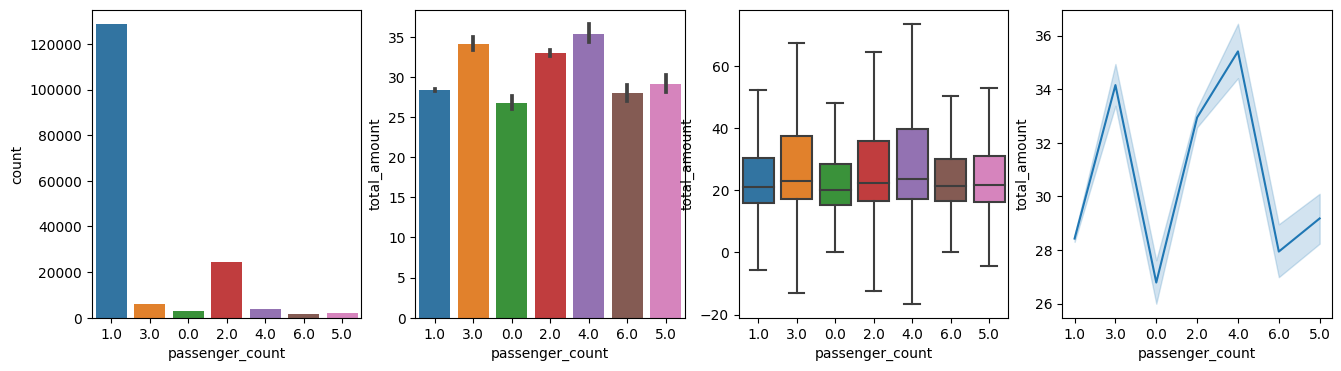

In [31]:
explore_categorical(traindf.loc[traindf['passenger_count'] < 8], 'passenger_count', 'total_amount', pairwise_t=True)

In [32]:
### trip_distance

Descriptive statistics for trip_distance:

 count    175000.000000
mean          3.674865
std           4.879881
min           0.000000
25%           1.080000
50%           1.840000
75%           3.610000
max         143.350000
Name: trip_distance, dtype: float64

Statistical tests:

Correlation between trip_distance and total_amount: 0.8591269272353488
R2-score for SLR on trip_distance and total_amount: 0.7407635561383707

Plotting all the graphs...



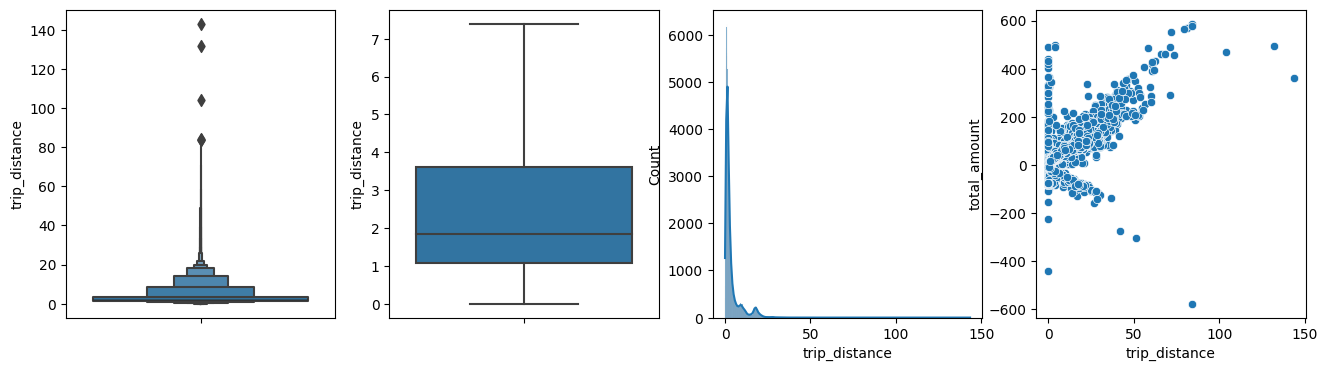

In [33]:
explore_continuous(traindf, "trip_distance", "total_amount")

In [34]:
### Try log transformation of trip_distance

Descriptive statistics for log_trip_distance:

 count    175000.000000
mean          0.683080
std           1.201231
min          -4.605170
25%           0.076961
50%           0.609766
75%           1.283708
max           4.965289
Name: log_trip_distance, dtype: float64

Statistical tests:

Correlation between log_trip_distance and total_amount: 0.6202428875284031
R2-score for SLR on log_trip_distance and total_amount: 0.3963340741907527

Plotting all the graphs...



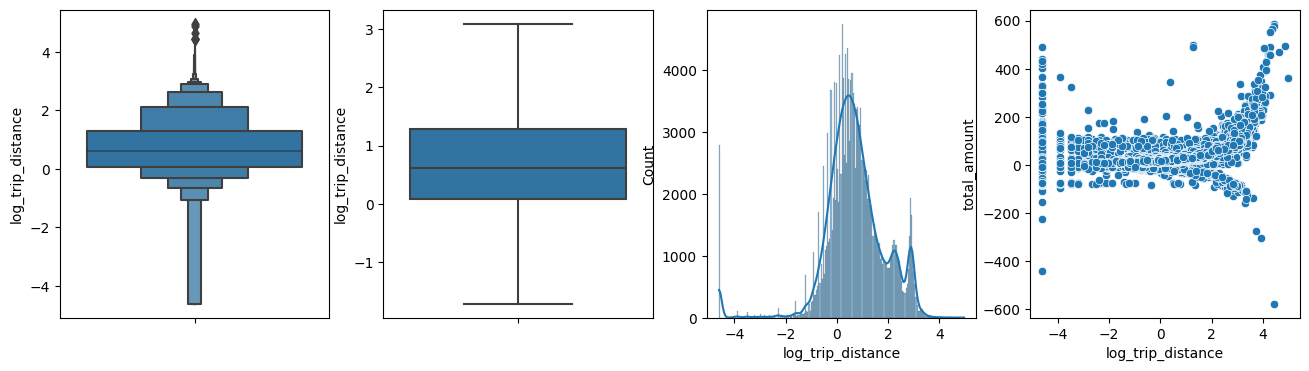

In [35]:
explore_continuous(traindf, "log_trip_distance", "total_amount")

In [36]:
### RatecodeID

value_counts for RatecodeID:

 RatecodeID
1.0      158652
2.0        7314
999.0      6077
5.0        1036
99.0        748
3.0         727
4.0         446
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 0.0

Plotting all the graphs...



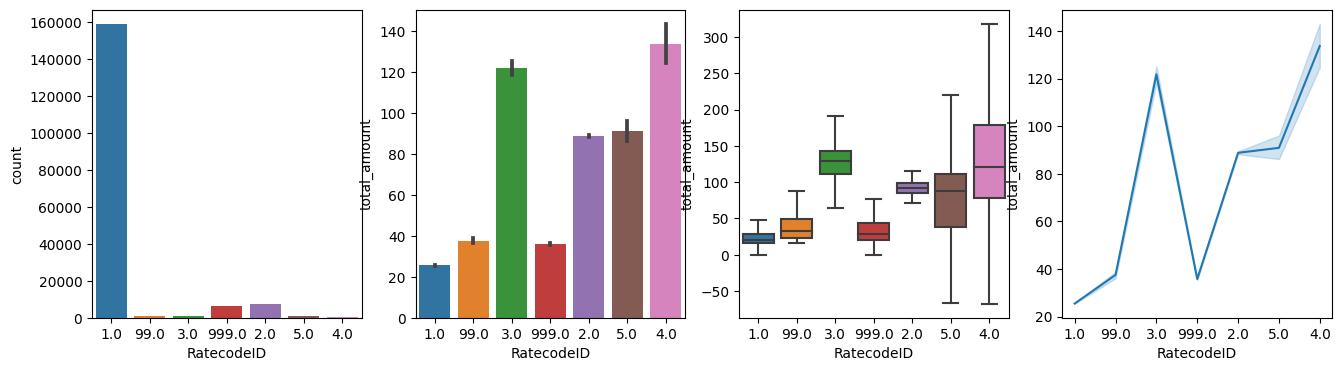

In [37]:
explore_categorical(traindf, 'RatecodeID', 'total_amount', pairwise_t=False)

In [38]:
### store_and_fwd_flag 

value_counts for store_and_fwd_flag:

 store_and_fwd_flag
N     167729
NA      6077
Y       1194
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 2.4909802523124474e-83

Pair-wise t-tests done.
P-value from t-test for N vs NA: 2.3703995435510708e-82
P-value from t-test for N vs Y: 0.0040787303120306245
P-value from t-test for NA vs Y: 1.111562635224014e-33
None

Plotting all the graphs...



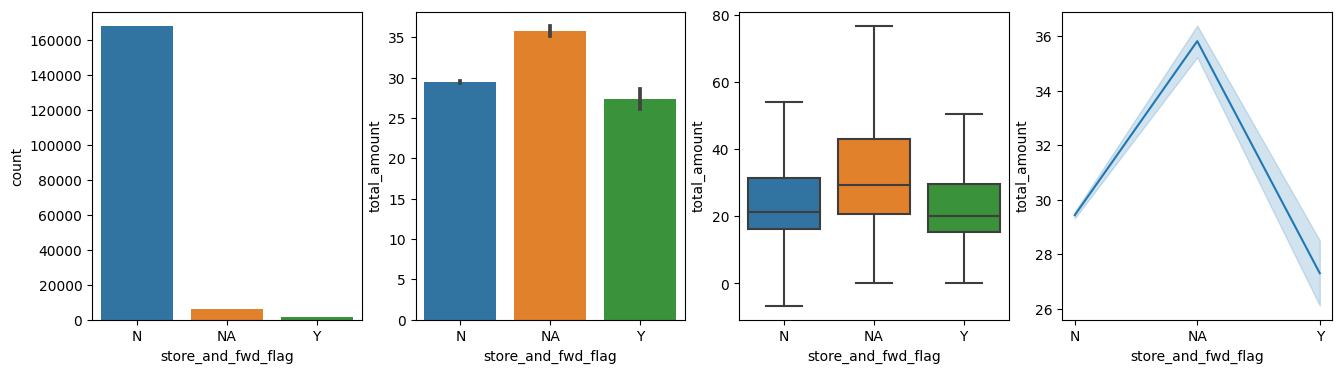

In [39]:
explore_categorical(traindf, "store_and_fwd_flag", "total_amount")

In [40]:
### PULocationID 

<Axes: xlabel='PULocationID', ylabel='Count'>

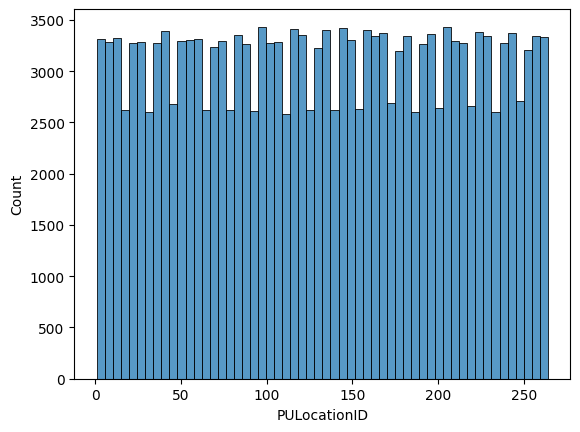

In [41]:
sns.histplot(data=traindf, x = "PULocationID")

In [42]:
traindf['PULocationID'].describe()

count    175000.000000
mean        132.710349
std          76.148799
min           1.000000
25%          67.000000
50%         133.000000
75%         199.000000
max         264.000000
Name: PULocationID, dtype: float64

In [43]:
# explore_categorical(traindf, "PULocationID", "total_amount", pairwise_t=False)

In [44]:
### DOLocationID

<Axes: xlabel='DOLocationID', ylabel='Count'>

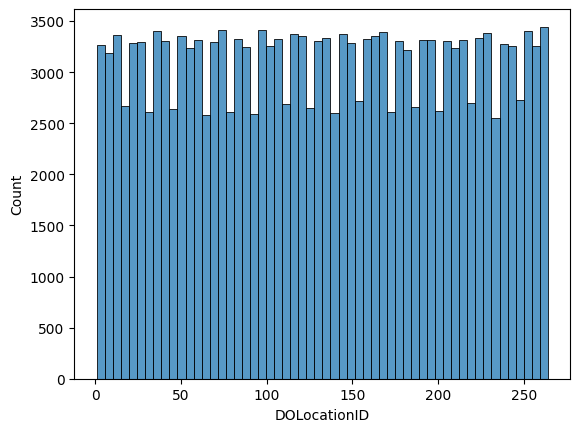

In [45]:
sns.histplot(data=traindf, x = "DOLocationID")

In [46]:
traindf['DOLocationID'].describe()

count    175000.000000
mean        132.701429
std          76.192493
min           1.000000
25%          67.000000
50%         133.000000
75%         199.000000
max         264.000000
Name: DOLocationID, dtype: float64

In [47]:
# explore_categorical(traindf, "DOLocationID", "total_amount", pairwise_t=False)

In [48]:
### payment_type

value_counts for payment_type:

 payment_type
Credit Card    135257
Cash            30141
Wallet           6077
unknown          2333
UPI              1192
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 0.0

Pair-wise t-tests done.
P-value from t-test for Credit Card vs Cash: 1.9708331486274594e-211
P-value from t-test for Credit Card vs Wallet: 4.6692714515297736e-54
P-value from t-test for Credit Card vs UPI: 1.4026596031928948e-141
P-value from t-test for Credit Card vs unknown: 0.0
P-value from t-test for Cash vs Wallet: 2.828250175776567e-178
P-value from t-test for Cash vs UPI: 1.0288996232677597e-70
P-value from t-test for Cash vs unknown: 0.0
P-value from t-test for Wallet vs UPI: 5.996927050620652e-185
P-value from t-test for Wallet vs unknown: 0.0
P-value from t-test for UPI vs unknown: 1.9978328549483768e-12
None

Plotting all the graphs...



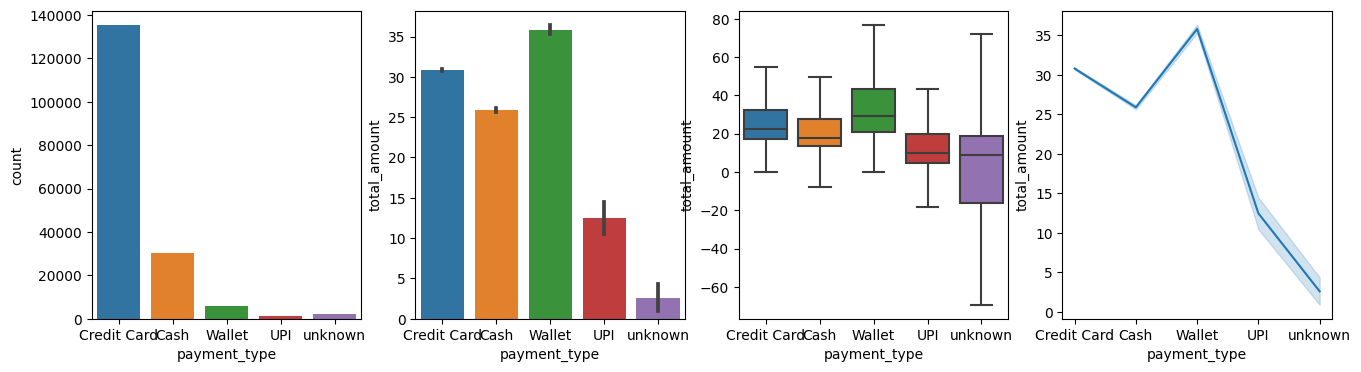

In [49]:
explore_categorical(traindf, "payment_type", "total_amount")

In [50]:
### extra

Descriptive statistics for extra:

 count    175000.000000
mean          1.932143
std           1.948497
min          -7.500000
25%           0.000000
50%           1.000000
75%           2.500000
max          11.750000
Name: extra, dtype: float64

Statistical tests:

Correlation between extra and total_amount: 0.23434626695029745
R2-score for SLR on extra and total_amount: 0.05531304915585089

Plotting all the graphs...



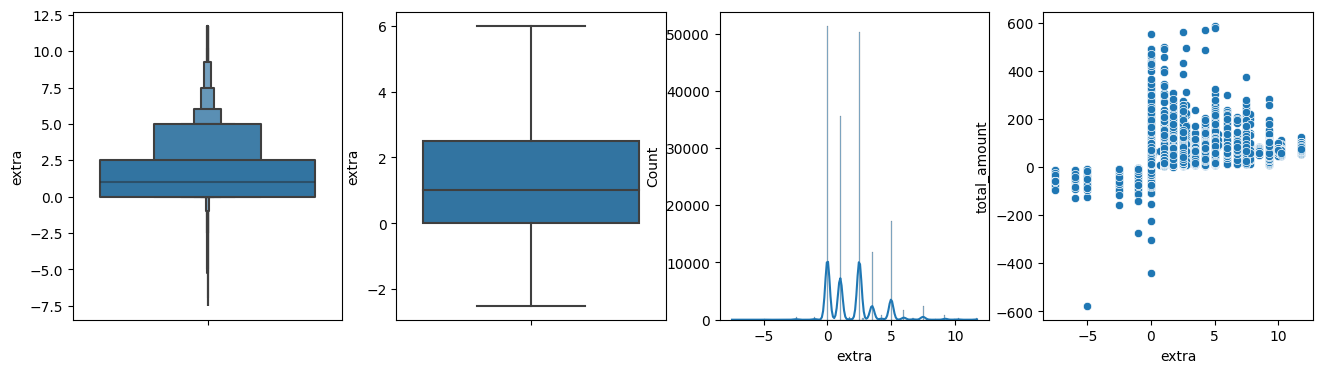

In [51]:
explore_continuous(traindf, "extra", "total_amount")

In [52]:
traindf['extra'].value_counts()

extra
 0.00     51247
 2.50     50180
 1.00     35614
 5.00     17280
 3.50     11839
 7.50      2351
 6.00      1774
 4.25       871
 9.25       812
-1.00       514
-2.50       472
 1.75       413
 2.75       375
 6.75       284
 11.75      258
 10.25      231
 7.75       199
 10.00       96
-5.00        76
 8.50        56
-7.50        22
-6.00        21
 5.25         8
 0.75         2
 3.25         2
 0.25         1
 0.11         1
 1.50         1
Name: count, dtype: int64

In [53]:
### tip_amount

Descriptive statistics for tip_amount:

 count    175000.000000
mean          6.127497
std           4.610834
min           0.000079
25%           3.473321
50%           5.286217
75%           7.502746
max         484.876151
Name: tip_amount, dtype: float64

Statistical tests:

Correlation between tip_amount and total_amount: 0.6386583543797576
R2-score for SLR on tip_amount and total_amount: 0.42554358086300825

Plotting all the graphs...



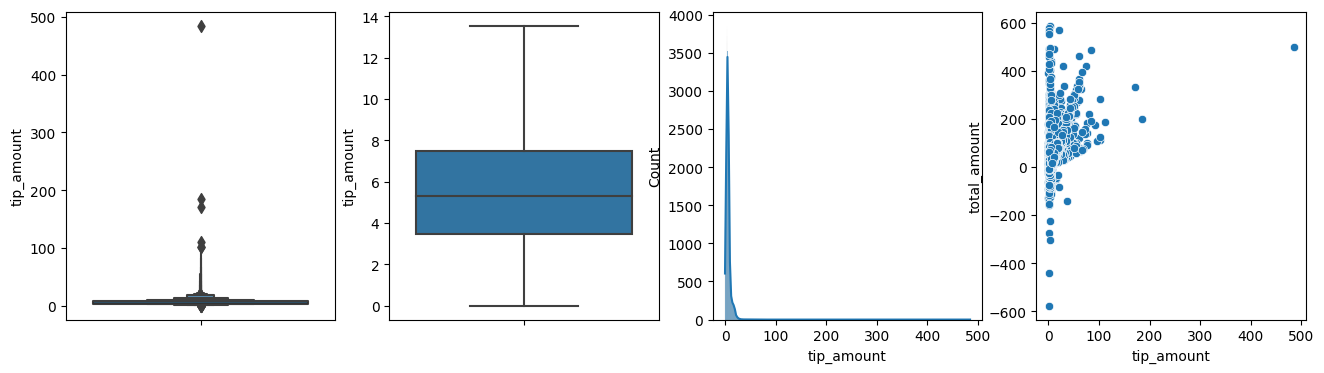

In [54]:
explore_continuous(traindf, "tip_amount", "total_amount")

In [55]:
### tolls_amount

Descriptive statistics for tolls_amount:

 count    175000.000000
mean          0.646816
std           2.328274
min         -29.300000
25%           0.000000
50%           0.000000
75%           0.000000
max          80.000000
Name: tolls_amount, dtype: float64

Statistical tests:

Correlation between tolls_amount and total_amount: 0.6847650291240797
R2-score for SLR on tolls_amount and total_amount: 0.4498609493006819

Plotting all the graphs...



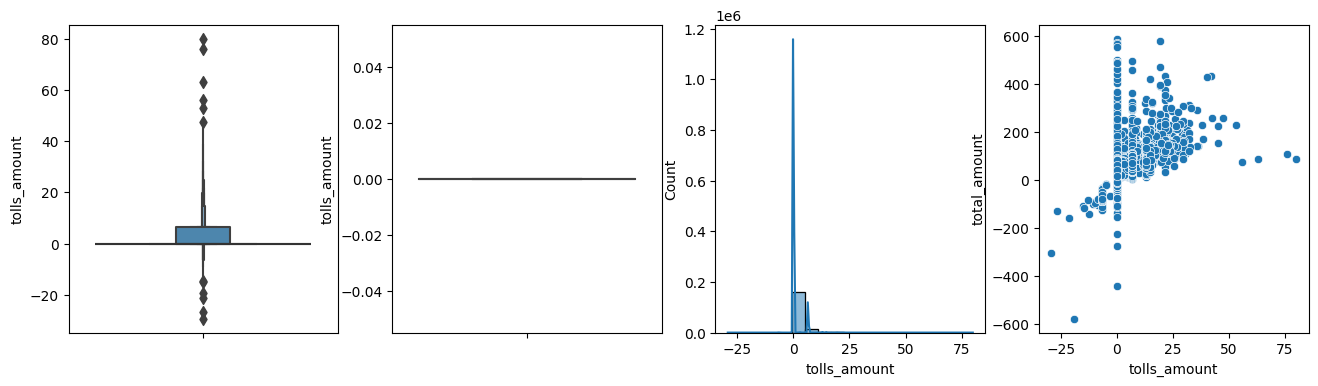

In [56]:
explore_continuous(traindf, "tolls_amount", "total_amount")

In [57]:
### improvement_surcharge

value_counts for improvement_surcharge:

 improvement_surcharge
 1.0    173145
-1.0      1725
 0.3        85
 0.0        45
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 0.0

Pair-wise t-tests done.
P-value from t-test for 1.0 vs 0.3: 1.5816444256314217e-06
P-value from t-test for 1.0 vs -1.0: 0.0
P-value from t-test for 1.0 vs 0.0: 0.2791044057927122
P-value from t-test for 0.3 vs -1.0: 1.1521751843676885e-84
P-value from t-test for 0.3 vs 0.0: 0.0021001218997557095
P-value from t-test for -1.0 vs 0.0: 8.907074735127583e-29
None

Plotting all the graphs...



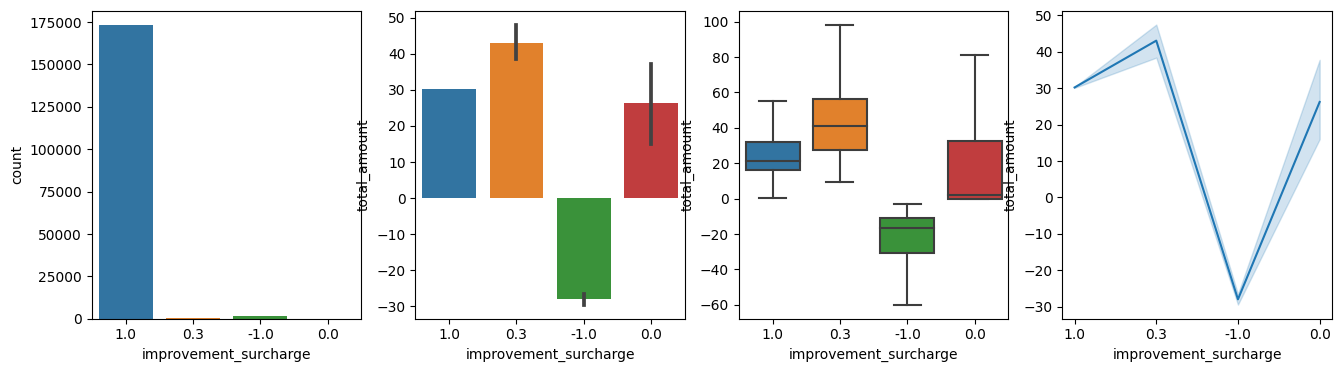

In [58]:
explore_categorical(traindf, "improvement_surcharge", "total_amount")

In [59]:
### congestion_surcharge

value_counts for congestion_surcharge:

 congestion_surcharge
 2.5    153212
 0.0     14325
 1.0      6077
-2.5      1386
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 0.0

Pair-wise t-tests done.
P-value from t-test for 2.5 vs 0.0: 0.0
P-value from t-test for 2.5 vs 1.0: 3.531433725919328e-217
P-value from t-test for 2.5 vs -2.5: 0.0
P-value from t-test for 0.0 vs 1.0: 9.267734873830074e-173
P-value from t-test for 0.0 vs -2.5: 0.0
P-value from t-test for 1.0 vs -2.5: 0.0
None

Plotting all the graphs...



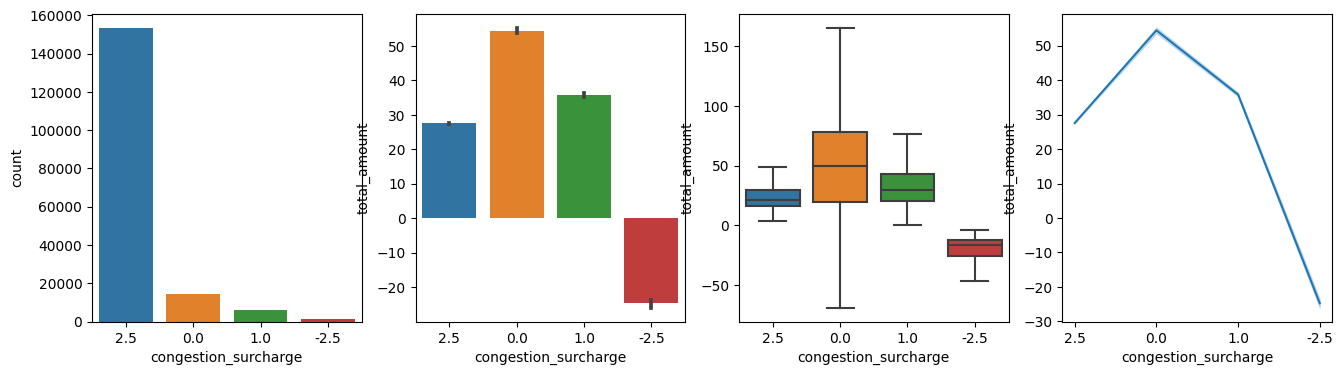

In [60]:
explore_categorical(traindf, "congestion_surcharge", "total_amount")

In [61]:
### Airport_fee

value_counts for Airport_fee:

 Airport_fee
 0.00    153074
 1.75     15590
 1.00      6077
-1.75       259
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 0.0

Pair-wise t-tests done.
P-value from t-test for 0.0 vs 1.75: 0.0
P-value from t-test for 0.0 vs 1.0: 0.0
P-value from t-test for 0.0 vs -1.75: 0.0
P-value from t-test for 1.75 vs 1.0: 0.0
P-value from t-test for 1.75 vs -1.75: 0.0
P-value from t-test for 1.0 vs -1.75: 0.0
None

Plotting all the graphs...



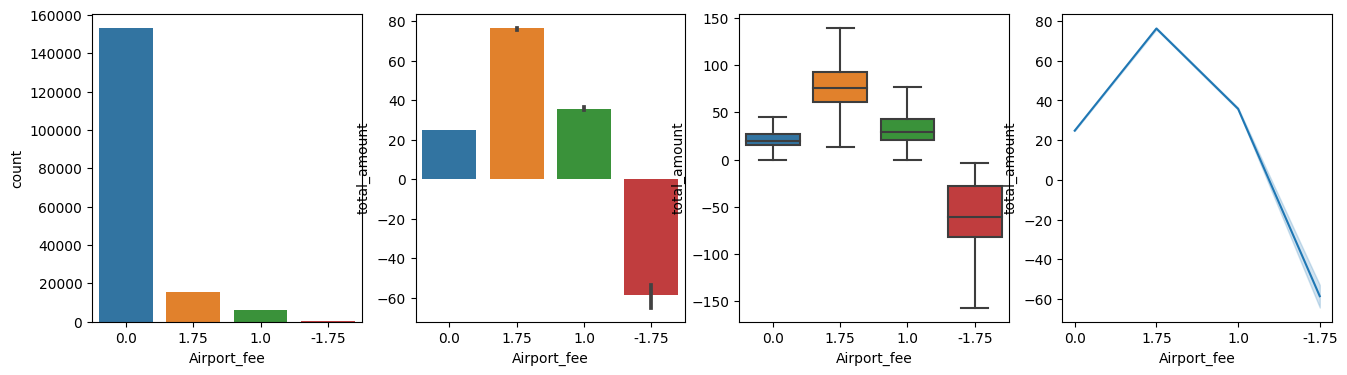

In [62]:
explore_categorical(traindf, "Airport_fee", "total_amount")

In [63]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               175000 non-null  int64         
 1   tpep_pickup_datetime   175000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  175000 non-null  datetime64[ns]
 3   passenger_count        175000 non-null  float64       
 4   trip_distance          175000 non-null  float64       
 5   RatecodeID             175000 non-null  float64       
 6   store_and_fwd_flag     175000 non-null  object        
 7   PULocationID           175000 non-null  int64         
 8   DOLocationID           175000 non-null  int64         
 9   payment_type           175000 non-null  object        
 10  extra                  175000 non-null  float64       
 11  tip_amount             175000 non-null  float64       
 12  tolls_amount           175000 non-null  floa

In [64]:
### pu_day

value_counts for pu_day:

 pu_day
29    73709
30    66037
28    34510
1       744
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 9.051214946042326e-19

Pair-wise t-tests done.
P-value from t-test for 28 vs 29: 3.818140037891802e-11
P-value from t-test for 28 vs 30: 0.5817347557041298
P-value from t-test for 28 vs 1: 0.37733744010368997
P-value from t-test for 29 vs 30: 1.4360321480040796e-17
P-value from t-test for 29 vs 1: 0.7471973211710159
P-value from t-test for 30 vs 1: 0.35768358733829775
None

Plotting all the graphs...



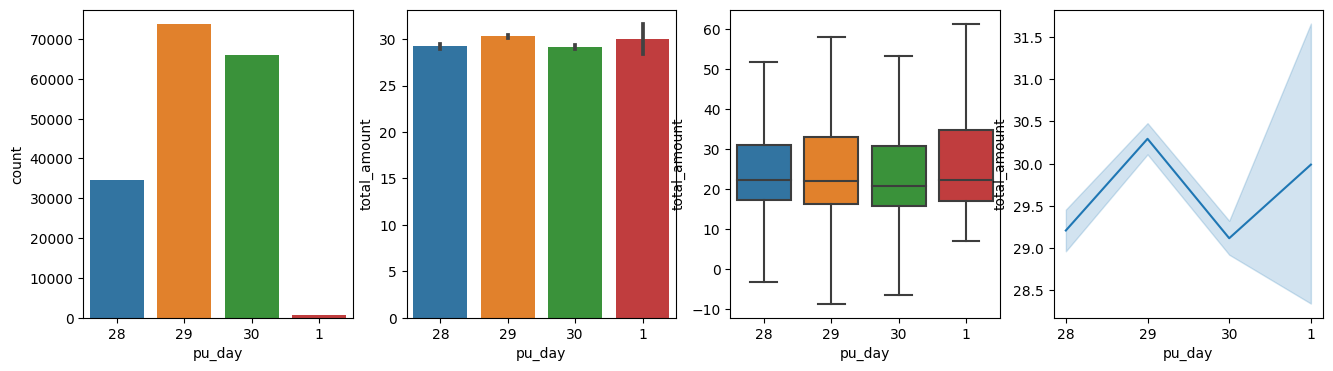

In [65]:
explore_categorical(traindf, "pu_day", "total_amount")

In [66]:
### pu_hr

value_counts for pu_hr:

 pu_hr
18    14798
17    13920
19    13824
20    12154
21    11943
22    11259
16    11108
15     8962
23     8908
14     8576
13     8027
12     7640
11     7185
10     6630
9      6183
8      5440
0      5038
7      4021
1      2460
6      2414
2      1416
5      1272
3       944
4       878
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 1.4929826076752285e-197

Plotting all the graphs...



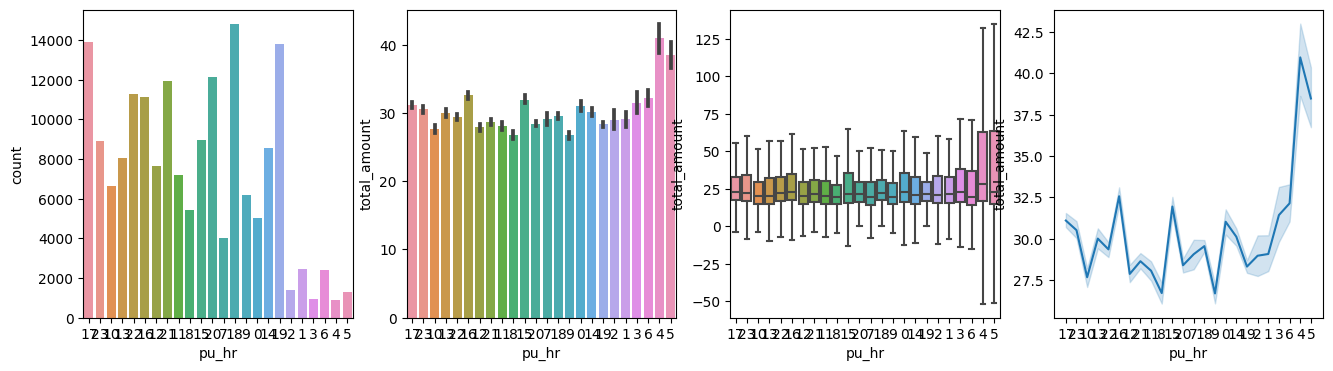

In [67]:
explore_categorical(traindf, "pu_hr", "total_amount", pairwise_t=False)

In [68]:
### do_day

value_counts for do_day:

 do_day
29    73611
30    66311
28    33725
1      1353
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 3.5903450894385905e-42

Pair-wise t-tests done.
P-value from t-test for 28 vs 29: 2.6144726888459435e-21
P-value from t-test for 28 vs 30: 0.004318610806909584
P-value from t-test for 28 vs 1: 3.605304950573702e-29
P-value from t-test for 29 vs 30: 5.695730678242838e-15
P-value from t-test for 29 vs 1: 8.263747482569265e-16
P-value from t-test for 30 vs 1: 1.5211802110304775e-21
None

Plotting all the graphs...



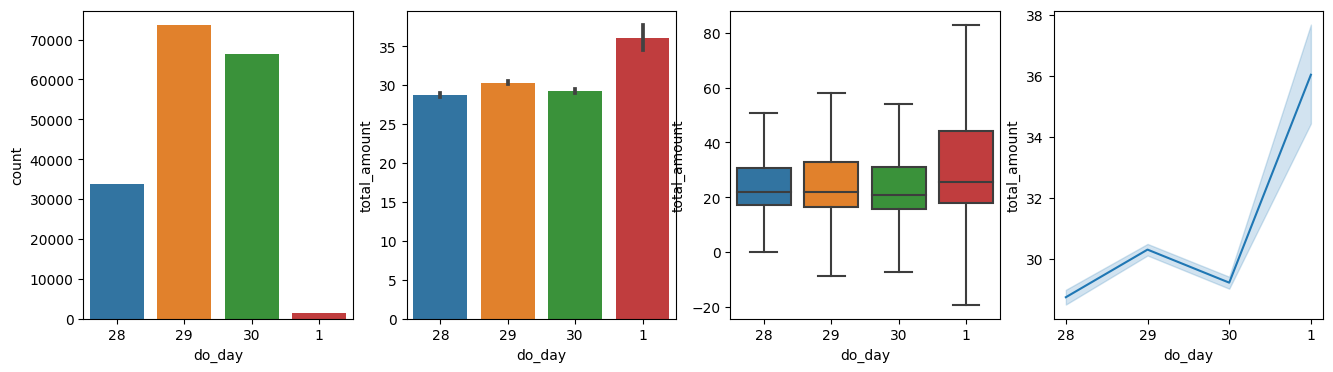

In [69]:
explore_categorical(traindf, "do_day", "total_amount")

In [70]:
### do_hr

value_counts for do_hr:

 do_hr
18    15486
19    14288
17    13487
20    12581
21    11982
22    11470
16    10250
23     9474
15     8551
14     8224
13     7898
12     7440
11     6948
10     6320
0      6100
9      5985
8      5091
7      3637
1      3060
6      2127
2      1652
5      1104
3      1000
4       845
Name: count, dtype: int64

Statistical tests:

ANOVA test done. P-value: 2.818390048262804e-206

Plotting all the graphs...



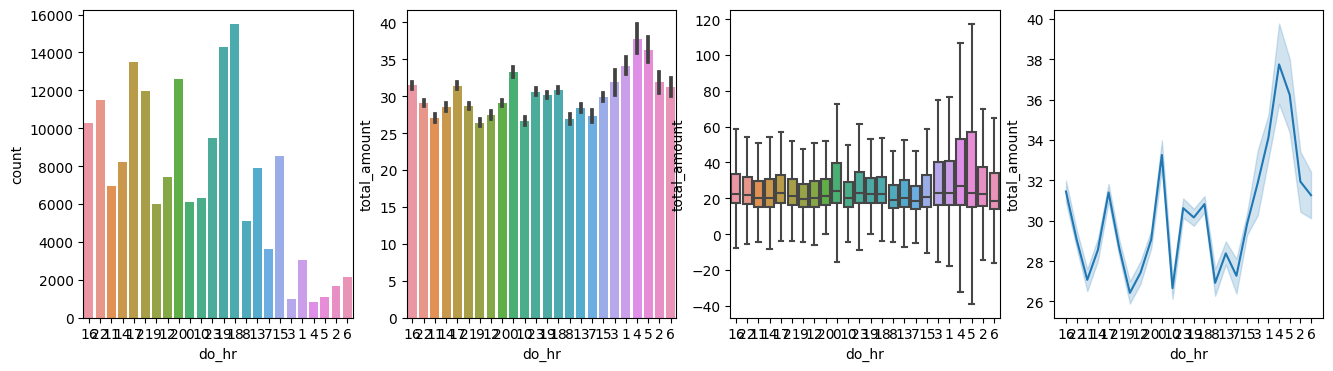

In [71]:
explore_categorical(traindf, "do_hr", "total_amount", pairwise_t=False)

In [72]:
# Correlation

In [73]:
cont_vars = ['trip_distance', 'extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']

In [74]:
corr_matrix = traindf[cont_vars + ['total_amount']].corr()
corr_matrix

,trip_distance,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,total_amount
trip_distance,1.000000,0.149295,0.505075,0.632367,0.006321,-0.269830,0.605445,0.859127
extra,0.149295,1.000000,0.160331,0.201179,0.170831,0.109601,0.268730,0.234346
tip_amount,0.505075,0.160331,1.000000,0.411588,0.076436,-0.060084,0.320005,0.638658
tolls_amount,0.632367,0.201179,0.411588,1.000000,0.051190,-0.138521,0.417829,0.684765
improvement_surcharge,0.006321,0.170831,0.076436,0.051190,1.000000,0.504051,0.083154,0.224036
congestion_surcharge,-0.269830,0.109601,-0.060084,-0.138521,0.504051,1.000000,-0.388986,-0.152676
Airport_fee,0.605445,0.268730,0.320005,0.417829,0.083154,-0.388986,1.000000,0.576856
total_amount,0.859127,0.234346,0.638658,0.684765,0.224036,-0.152676,0.576856,1.000000


<Axes: >

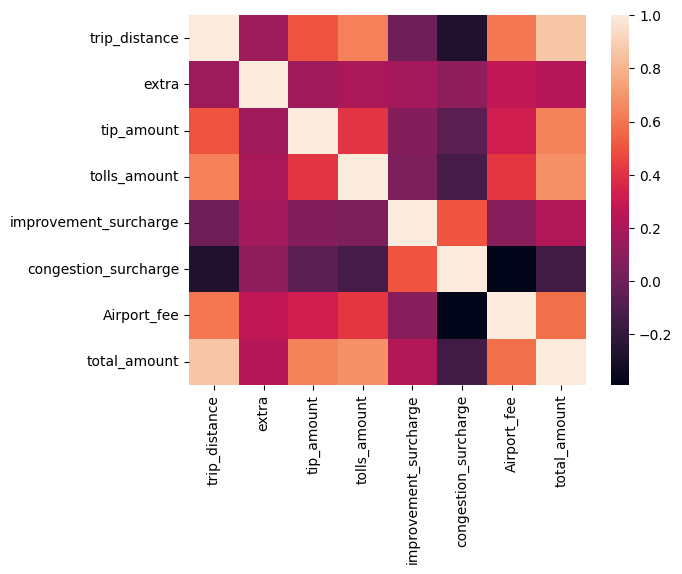

In [75]:
sns.heatmap(data=corr_matrix)

In [76]:
# SLR

In [77]:
traindf.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee', 'pu_day', 'do_day', 'pu_hr',
       'do_hr', 'pu_hr_sin', 'pu_hr_cos', 'do_hr_sin', 'do_hr_cos',
       'log_trip_distance', 'put', 'dot', 'travel_time', 'pu', 'do', 'pudo'],
      dtype='object')

In [78]:
scores = []
for feature in cont_vars:
    r2 = slr(traindf, feature, 'total_amount')
#     print(f"r2_score of {feature} is {r2}")
    scores.append(r2)
    
pd.DataFrame({"feature": cont_vars, "r2_score": scores})

,feature,r2_score
0,trip_distance,0.740764
1,extra,0.055313
2,tip_amount,0.425544
3,tolls_amount,0.449861
4,improvement_surcharge,0.051552
5,congestion_surcharge,0.023100
6,Airport_fee,0.327857


In [79]:
## Feature selection  

In [80]:
# RFE

# Model building

## Helper functions  

In [81]:
def build_pipeline(selected_model = Ridge(),
                   selected_features = {
                                        'num': ['trip_distance'],
                                        'cat': ['VendorID']
                                        },
                   param_grid = None,
                   poly=False,
                   use_pca=False
                  ):
    
    # Numerical features
    num_pipe = Pipeline(steps=[
#                             ("robscaler", RobustScaler()),
#                             ("minmaxscaler", MinMaxScaler()),
                            ("stdscaler", StandardScaler())
                        ])
    num_pipe_poly = Pipeline(steps=[
#                             ("robscaler", RobustScaler()),
#                             ("minmaxscaler", MinMaxScaler()),
                            ("stdscaler", StandardScaler()),
                            ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
                        ])
    
    # Categorical features
    cat_pipe = Pipeline(steps=[
                            ("ohe", OneHotEncoder(handle_unknown='ignore')),
                        ])
    
    # Basic pipes
    TFs = []
    try:
        TFs.append((f"cat", cat_pipe, selected_features['cat']))
    except:
        pass
    
    try:
        if poly:
            TFs.append((f"num", num_pipe_poly, selected_features['num']))
        else:
            TFs.append((f"num", num_pipe, selected_features['num']))
    except:
        pass
    
    # Build ColumnTransformer  
    ct = ColumnTransformer(transformers=TFs, remainder='drop')

    # Build Pipeline
    pipe = Pipeline(steps=[('ct', ct), ('model', selected_model)])
    
    if use_pca:
            print("\nNote: TruncatedSVD used in the pipeline.")
            try:
                tr_svd = TruncatedSVD(n_components=use_pca)
            except:
                tr_svd = TruncatedSVD(n_components=100)
            tr_svd_step = ('tr_svd', tr_svd)
            pipe.steps.insert(1, tr_svd_step)
            
    print("\nPipeline built successfully.")

    # Use the pipe in GridSearchCV
    if param_grid == None:
        param_grid_temp = {
#                             "model__alpha": [1.0],
#                             "model__tol": [0.0001],
#                            "model__solver": ["auto"],
                          }
        print("Full GridSearchCV pipeline built successfully with basic default param_grid.\n")
        pipeCV = GridSearchCV(pipe, param_grid_temp, cv=10, scoring="r2", n_jobs=-1)
        print(pipeCV)
        return pipeCV
    
    # GridSearchCV if param_grid provided
    if param_grid:
        pipeCV = GridSearchCV(pipe, param_grid, cv=10, scoring="r2", n_jobs=-1)
        print("\nFull GridSearchCV pipeline built successfully.")
        print(pipeCV)
        return pipeCV

In [82]:
def preprocessor(imputer_type="simple", fill_missing=True):
    """Preprocess train or test data. Choose 'simple' or 'knn' imputers to impute missing numerical values"""
    
    # Set imputer  
#     if imputer_type == 'simple':
#         imputer = SimpleImputer(strategy='median')
#         print(imputer)
#     elif imputer_type == 'knn':
#         imputer = KNNImputer(weights='distance', n_neighbors=3)    # Adjust KNNImputer params here
#         print(imputer)
        
    # Load data
    traindf = load_data('train')
    testdf = load_data('test')
    print(f"Train and test datasets loaded.")
    
    # Clean data
    clean_data(traindf, fill_missing=fill_missing)
    clean_data(testdf, fill_missing=fill_missing)
    print(f"Basic cleaning of train and test data done.")
    
    return traindf, testdf

In [83]:
# Build a single submit function
def submit_v2(selected_model = Ridge(),
              selected_features = {
                                    'num': ['trip_distance'],
                                    'cat': ['VendorID'],
                                  },
              fill_missing=True,
              param_grid = None,
              poly=False,
              use_pca=False
             ):
    
    # Load and preprocess data
    traindf, testdf = preprocessor(fill_missing=fill_missing)
    
    # Build pipeline
    pipe = build_pipeline(selected_model,
                          selected_features,
                          param_grid,
                          poly,
                          use_pca
                         )
    
    # Create X_train, y_train
    X_train = traindf.drop(labels="total_amount", axis=1)
    y_train = traindf["total_amount"]
    print(f"\nX_train and y_train created.")
    print(f"Shape of X_train: { X_train.shape}")
    print(f"Columns in X_train: {X_train.columns}")
#     print(X_train.isna().sum())
    print(f"\nShape of y_train: { y_train.shape}")
    print(f"Inspect y_train:\n {y_train.head()}")
    
    # Create X_test
    X_test = testdf.copy()
    print(f"\nX_test created.")
    print(f"Shape of X_test: { X_test.shape}")
    print(f"Columns in X_test: {X_test.columns}")
    
    # Train
    print(f"\nTraining with full GridSearchCV pipeline started...")
    pipe.fit(X_train, y_train)
    print(f"Training completed.")
    print(f"\nNumber of features after column transformer: {pipe.n_features_in_}")
    if use_pca:
            print(f"\nNumber of components after applying TruncatedSVD: {pipe.best_estimator_.named_steps.tr_svd.components_.shape}")
            print(f"Explained variance ratios: {pipe.best_estimator_.named_steps.tr_svd.explained_variance_ratio_}")
            print(f"Sum of explained variance ratios: {np.sum(pipe.best_estimator_.named_steps.tr_svd.explained_variance_ratio_)}")

    print(f"\nBest estimator: {pipe.best_estimator_}")
    print(f"\nBest params: {pipe.best_params_}")
    print(f"\nBest score: {pipe.best_score_}")
    try:
        print(f"\nIntercept: {pipe.best_estimator_.named_steps.model.intercept_}")
        print(f"\nCo-efficients: {pipe.best_estimator_.named_steps.model.coef_}")
    except:
        print(f"\nOops.. Something went wrong in the try block")
    
    # Predict
    print(f"\nPredicting on 'test.csv' data...")
    y_pred = pipe.predict(X_test)
    
    # Create 'submission.csv' file
    pred_df = pd.DataFrame(y_pred)
    pred_df.columns = ["total_amount"]
    pred_df.index += 1
    pred_df.index.name = "ID"
#     print(pred_df.shape)
#     print(pred_df.head())
    pred_df.to_csv("submission.csv")
    print(f"\nSuccessfully created the submission file!!!")

    # Plot the predictions
    print(f"\nShape of pred_df: {pred_df.shape}")
    print(f"\nInspect pred_df:\n {pred_df.head()}")
    print(f"\nDescribe pred_df:\n {pred_df.describe()}")
    sns.boxplot(pred_df, y="total_amount")
    
    # Return
    print(f"\nSuccessfully created the submission file!!!")
    return pred_df

# Submit using submit_v2 function

In [84]:
# Param grids
param_grid_sgdr = {
                "model__loss": ["squared_error"],
                "model__penalty": ["l2"],
                "model__alpha": [0.0001],
                "model__tol": [0.001],
                "model__epsilon": [0.1],
                "model__eta0": [0.01],
                "model__power_t": [0.25],
                "model__n_iter_no_change": [100],
                "model__max_iter": [10000],
                }

param_grid_svr = {
                "model__kernel": ["rbf"],
                "model__degree": [3],
                "model__gamma": ["scale"],
                "model__coef0": [0.0],
                "model__tol": [0.001],
                "model__C": [1],
                "model__epsilon": [0.1],
                "model__max_iter": [-1],
                }

param_grid_nusvr = {
                "model__nu": [0.5],
                "model__C": [1],
                "model__kernel": ["rbf"],
                "model__degree": [3],
                "model__gamma": ["scale"],
                "model__coef0": [0.0],
                "model__tol": [0.001],
                "model__max_iter": [-1],
                }

param_grid_linearsvr = {
                "model__epsilon": [0.0],
                "model__tol": [0.0001],
                "model__C": [1],
                "model__max_iter": [1000],
                }

param_grid_rfr = {
                "model__criterion": ["squared_error", "friedman_mse", "poisson"],
                "model__max_features": [1.0, "sqrt", "log2", None],
                }

param_grid_mlpr = {
                "model__solver": ["adam"],
                "model__alpha": [0.0001, 0.01],
                "model__learning_rate": ["constant", "invscaling", "adaptive"],
                "model__max_iter": [500, 1000],
                }

param_grid_mlpr_best = {
                "model__solver": ["adam"],
                "model__alpha": [0.01, 0.1],
                "model__learning_rate": ["constant"],
                "model__max_iter": [500, 1000],
                }

In [85]:
traindf.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee', 'pu_day', 'do_day', 'pu_hr',
       'do_hr', 'pu_hr_sin', 'pu_hr_cos', 'do_hr_sin', 'do_hr_cos',
       'log_trip_distance', 'put', 'dot', 'travel_time', 'pu', 'do', 'pudo'],
      dtype='object')

Train and test datasets loaded.
Basic cleaning of train and test data done.

Note: TruncatedSVD used in the pipeline.

Pipeline built successfully.

Full GridSearchCV pipeline built successfully.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['payment_type',
                                                                          'RatecodeID',
                                                                          'VendorID',
                                                                          'passenger_count',
                                                                       

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training completed.

Number of features after column transformer: 31

Number of components after applying TruncatedSVD: (40, 34771)
Explained variance ratios: [1.06880472e-01 1.28566273e-01 1.44511127e-01 1.15937308e-01
 1.03128131e-01 6.87897529e-02 6.14069726e-02 5.16170143e-02
 4.16080483e-02 2.41752276e-02 2.03930334e-02 1.57859096e-02
 1.32953854e-02 1.01791354e-02 5.81212046e-03 3.83985908e-03
 2.80768299e-03 2.40525030e-03 2.01925147e-03 1.79428195e-03
 1.21300023e-03 9.37452419e-04 8.46760967e-04 6.74217003e-04
 5.81884009e-04 4.93185420e-04 3.14257741e-04 2.49561615e-04
 1.83434649e-04 3.06854286e-05 5.64173177e-06 5.28057663e-06
 5.22674383e-06 5.05669480e-06 5.02296731e-06 4.99334501e-06
 4.95196583e-06 4.86315379e-06 4.80112525e-06 4.77643658e-06]
Sum of explained variance ratios: 0.930527291108035

Best estimator: Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
       

,total_amount
ID,
1,33.943840
2,26.109924
3,15.464919
4,14.735867
5,25.174643
...,...
49996,16.024880
49997,25.622040
49998,20.905089


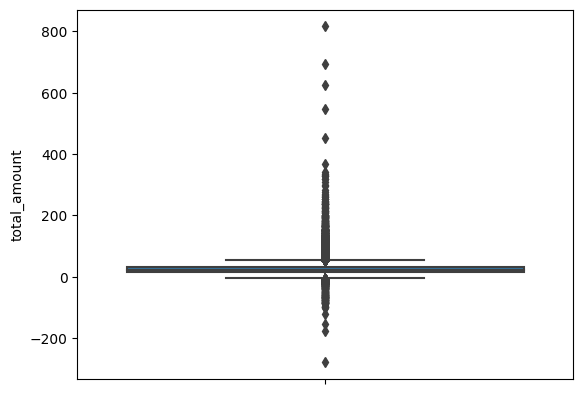

In [86]:
# Features
sel_cat_vars = [
                'VendorID', 'store_and_fwd_flag', 'passenger_count',  
                'payment_type', 'RatecodeID',
                'PULocationID', 'DOLocationID',
#                 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee',
                'pu_day', 'pu_hr', 'do_day', 'do_hr',
                'pudo',
               ]

sel_num_vars = [
                'trip_distance', 'extra', 'tip_amount', 'tolls_amount',
                'improvement_surcharge', 'congestion_surcharge', 'Airport_fee',
                'travel_time',
                ]

# Minimal set
cat_vars_min = [
                'payment_type', 'RatecodeID',
#                 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee',
                'VendorID', 
#                 'pu_hr', 
                'passenger_count', 
                'pudo', 
                ]
num_vars_min = [
                'trip_distance', 'extra', 'tip_amount', 'tolls_amount', 'travel_time', 
                'improvement_surcharge', 'congestion_surcharge', 'Airport_fee',
                'pu_hr_sin', 'pu_hr_cos',
                'do_hr_sin', 'do_hr_cos',
                ]

# skinny set
cat_vars_skinny = [
                'RatecodeID',
#                 'improvement_surcharge', 
#                 'Airport_fee',
                'VendorID', 
#                 'extra', 
                'payment_type'
                ]
num_vars_skinny = [
                'trip_distance', 
                'extra', 
                'tip_amount', 
                'tolls_amount', 
                'improvement_surcharge', 
                'Airport_fee',
                'travel_time',
                ]

# Model
model = MLPRegressor()


# call submit_v2 function
submit_v2(  selected_model = model,
            selected_features = {
                                    'cat': cat_vars_min,
                                    'num': num_vars_min,
                                  },
            fill_missing=True,
            param_grid = param_grid_mlpr_best,
            use_pca=40)

# Results

In [87]:
print("See above!")

See above!


# PCA  

In [88]:
dff = traindf[cat_vars_min + num_vars_min].copy()
dff.shape, dff.columns

((175000, 17),
 Index(['payment_type', 'RatecodeID', 'VendorID', 'passenger_count', 'pudo',
        'trip_distance', 'extra', 'tip_amount', 'tolls_amount', 'travel_time',
        'improvement_surcharge', 'congestion_surcharge', 'Airport_fee',
        'pu_hr_sin', 'pu_hr_cos', 'do_hr_sin', 'do_hr_cos'],
       dtype='object'))

In [89]:
dff.head()

,payment_type,RatecodeID,VendorID,passenger_count,pudo,trip_distance,extra,tip_amount,tolls_amount,travel_time,improvement_surcharge,congestion_surcharge,Airport_fee,pu_hr_sin,pu_hr_cos,do_hr_sin,do_hr_cos
0,Credit Card,1.0,1,1.0,009120,2.14,2.5,7.165589,0.0,14.400000,1.0,2.5,0.0,-0.965926,-0.258819,-0.866025,-0.500000
1,Credit Card,1.0,0,1.0,015215,2.70,3.5,6.067401,0.0,56.566667,1.0,2.5,0.0,-0.258819,0.965926,-0.500000,0.866025
2,Credit Card,1.0,1,1.0,167223,1.15,0.0,4.111547,0.0,53.650000,1.0,2.5,0.0,0.500000,-0.866025,0.258819,-0.965926
3,Credit Card,1.0,0,1.0,128239,0.40,2.5,6.411079,0.0,56.866667,1.0,2.5,0.0,-0.258819,-0.965926,-0.500000,-0.866025
4,Credit Card,1.0,1,3.0,052203,1.10,1.0,4.769377,0.0,18.833333,1.0,2.5,0.0,-0.500000,0.866025,-0.500000,0.866025


In [90]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   payment_type           175000 non-null  object 
 1   RatecodeID             175000 non-null  float64
 2   VendorID               175000 non-null  int64  
 3   passenger_count        175000 non-null  float64
 4   pudo                   175000 non-null  object 
 5   trip_distance          175000 non-null  float64
 6   extra                  175000 non-null  float64
 7   tip_amount             175000 non-null  float64
 8   tolls_amount           175000 non-null  float64
 9   travel_time            175000 non-null  float64
 10  improvement_surcharge  175000 non-null  float64
 11  congestion_surcharge   175000 non-null  float64
 12  Airport_fee            175000 non-null  float64
 13  pu_hr_sin              175000 non-null  float64
 14  pu_hr_cos              175000 non-nu

In [91]:
ord_enc = OrdinalEncoder()
ord_enc

OrdinalEncoder()

In [92]:
dff['payment_type'] = ord_enc.fit_transform(dff['payment_type'].to_numpy().reshape(-1, 1))
dff.head()

,payment_type,RatecodeID,VendorID,passenger_count,pudo,trip_distance,extra,tip_amount,tolls_amount,travel_time,improvement_surcharge,congestion_surcharge,Airport_fee,pu_hr_sin,pu_hr_cos,do_hr_sin,do_hr_cos
0,1.0,1.0,1,1.0,009120,2.14,2.5,7.165589,0.0,14.400000,1.0,2.5,0.0,-0.965926,-0.258819,-0.866025,-0.500000
1,1.0,1.0,0,1.0,015215,2.70,3.5,6.067401,0.0,56.566667,1.0,2.5,0.0,-0.258819,0.965926,-0.500000,0.866025
2,1.0,1.0,1,1.0,167223,1.15,0.0,4.111547,0.0,53.650000,1.0,2.5,0.0,0.500000,-0.866025,0.258819,-0.965926
3,1.0,1.0,0,1.0,128239,0.40,2.5,6.411079,0.0,56.866667,1.0,2.5,0.0,-0.258819,-0.965926,-0.500000,-0.866025
4,1.0,1.0,1,3.0,052203,1.10,1.0,4.769377,0.0,18.833333,1.0,2.5,0.0,-0.500000,0.866025,-0.500000,0.866025


In [93]:
dff['payment_type'].value_counts()

payment_type
1.0    135257
0.0     30141
3.0      6077
4.0      2333
2.0      1192
Name: count, dtype: int64

In [94]:
pca = PCA(n_components=0.9999)
pca

PCA(n_components=0.9999)

In [95]:
pca.fit(dff)

PCA(n_components=0.9999)

In [96]:
pca.n_components_

1

In [97]:
pca.explained_variance_ratio_

array([0.99999075])

In [98]:
pca.components_

array([[ 1.15402454e-08,  8.28936155e-06, -2.44379842e-08,
         8.04509153e-07,  1.00000000e+00, -1.89360522e-07,
         8.59034419e-08,  5.06872749e-08, -5.52231126e-08,
        -3.64578609e-06, -6.70436408e-09,  3.84215421e-09,
        -2.15556946e-08,  1.66687706e-08,  1.56252291e-08,
         1.90220500e-08,  8.08374461e-09]])

In [99]:
pca.singular_values_

array([26034516.64924781])

### PCA on numerical features

In [100]:
df2 = traindf[num_vars_min].copy()
df2

,trip_distance,extra,tip_amount,tolls_amount,travel_time,improvement_surcharge,congestion_surcharge,Airport_fee,pu_hr_sin,pu_hr_cos,do_hr_sin,do_hr_cos
0,2.14,2.5,7.165589,0.0,14.400000,1.0,2.5,0.00,-0.965926,-0.258819,-8.660254e-01,-0.500000
1,2.70,3.5,6.067401,0.0,56.566667,1.0,2.5,0.00,-0.258819,0.965926,-5.000000e-01,0.866025
2,1.15,0.0,4.111547,0.0,53.650000,1.0,2.5,0.00,0.500000,-0.866025,2.588190e-01,-0.965926
3,0.40,2.5,6.411079,0.0,56.866667,1.0,2.5,0.00,-0.258819,-0.965926,-5.000000e-01,-0.866025
4,1.10,1.0,4.769377,0.0,18.833333,1.0,2.5,0.00,-0.500000,0.866025,-5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
174995,3.45,1.0,8.732495,0.0,31.416667,1.0,2.5,0.00,-0.500000,0.866025,-5.000000e-01,0.866025
174996,9.44,5.0,0.283275,0.0,61.400000,1.0,2.5,1.75,-0.258819,-0.965926,-5.000000e-01,-0.866025
174997,2.40,2.5,4.245354,0.0,70.033333,1.0,2.5,0.00,0.258819,-0.965926,1.224647e-16,-1.000000
174998,4.71,2.5,10.479776,0.0,21.633333,1.0,2.5,0.00,-0.965926,0.258819,-9.659258e-01,0.258819


In [101]:
pca2 = PCA(n_components=0.9999)
pca2

PCA(n_components=0.9999)

In [102]:
pca2.fit(df2)
pca2

PCA(n_components=0.9999)

In [103]:
pca2.n_components_

8

In [104]:
pca2.explained_variance_ratio_

array([9.73461029e-01, 1.68994318e-02, 5.34563222e-03, 1.85653642e-03,
       1.32767444e-03, 4.39388527e-04, 3.11229197e-04, 2.66561362e-04])

## Rough work